# Sismique passive : Rapports spectraux, méthode "H/V"

Recherche de la fréquence de résonnance du sol avec la méthode H/V

In [1]:
import pandas as pd
import os
import numpy as np
import glob
import datetime
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
from obspy import read, read_inventory, UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing
import scipy.signal

In [3]:
import re

In [4]:
df_antenne = pd.read_csv("data/position_nodes_antenne.csv", sep=',', index_col=0)
df_profil = pd.read_csv("data/position_nodes_profil.csv", sep=',', index_col=0)

In [5]:
path = 'data/nodes/' # chemin vers les données
coords = (47.6831736, 7.2543831)
files = os.listdir(path) # liste les fichiers miniseed du dossier ILLF
step = 60

In [6]:
def find_file(row, comp='Z'):
    regex = re.compile(f'.+{row["SN"]}\\..+\\.2024\\.09\\.04\\.1[2-5]\\..+\\.{'Z'}\\.miniseed')
    matches = [string for string in files if re.match(regex, string)]
    #print(len(matches), node)
    if matches:
        return matches[0]

In [7]:
df_antenne['file'] = df_antenne.apply(find_file, axis=1)
df_profil['file'] = df_profil.apply(find_file, axis=1)

In [8]:
df_antenne

Distance  Azimut    SN Heure_inst  \
Node                                       
R0            0       0  1268      14h07   
R1-01         5       0  5301      14h16   
R1-02         5      72   295      14h19   
R1-03         5     144   956      14h22   
R1-04         5     216   413      14h23   
R1-05         5     288  1828      14h24   
R2-01        10      36   679      14h26   
R2-02        10      96   908        15h   
R2-03        10     156   437      14h29   
R2-04        10     216  1076      14h31   
R2-05        10     276   891      14h32   
R2-06        10     336  8304      14h33   
R3-01        20      66   668      14h34   
R3-02        20     126   546      14h35   
R3-03        20     186   597      14h36   
R3-04        20     246  5325      14h37   
R3-05        20     306  2023      14h38   
R3-06        20       6  1106      14h39   
R4-01        40      96  2948      14h40   
R4-02        40     156   771      14h41   
R4-03        40     216   674      14h42   
R4-04        40     276  5270      14h43   
R4-05        40     336  2606      14h44   
R4-06        40      36  2194      14h45   

                                                 file  
Node                                                   
R0     453001268.5.2024.09.04.13.52.30.000.Z.miniseed  
R1-01  453005301.3.2024.09.04.13.49.10.000.Z.miniseed  
R1-02  453000295.7.2024.09.04.12.24.14.000.Z.miniseed  
R1-03  453000956.4.2024.09.04.12.53.18.000.Z.miniseed  
R1-04  453000413.7.2024.09.04.13.12.10.000.Z.miniseed  
R1-05  453001828.4.2024.09.04.12.43.10.000.Z.miniseed  
R2-01  453000679.4.2024.09.04.12.54.06.000.Z.miniseed  
R2-02  453000908.4.2024.09.04.13.35.18.000.Z.miniseed  
R2-03  453000437.4.2024.09.04.13.04.46.000.Z.miniseed  
R2-04  453001076.7.2024.09.04.12.40.10.000.Z.miniseed  
R2-05  453000891.4.2024.09.04.13.44.18.000.Z.miniseed  
R2-06  453018304.5.2024.09.04.13.28.54.000.Z.miniseed  
R3-01  453000668.4.2024.09.04.12.47.50.000.Z.miniseed  
R3-02  453000546.6.2024.09.04.13.36.58.000.Z.miniseed  
R3-03  453000597.7.2024.09.04.12.48.54.000.Z.miniseed  
R3-04  453005325.7.2024.09.04.12.59.50.000.Z.miniseed  
R3-05  453002023.7.2024.09.04.13.42.42.000.Z.miniseed  
R3-06  453001106.7.2024.09.04.13.08.54.000.Z.miniseed  
R4-01  453002948.6.2024.09.04.12.59.06.000.Z.miniseed  
R4-02  453000771.6.2024.09.04.12.52.26.000.Z.miniseed  
R4-03  453000674.6.2024.09.04.13.45.42.000.Z.miniseed  
R4-04  453005270.4.2024.09.04.12.47.50.000.Z.miniseed  
R4-05  453002606.6.2024.09.04.12.46.30.000.Z.miniseed  
R4-06  453002194.6.2024.09.04.13.10.34.000.Z.miniseed

Verifier qu'on a bien les fichiers, il doit avoir 3 traces pour chaque node.

In [9]:
for row in df_antenne.iterrows():
    node, serie = row
    regex = re.compile(f'.+{serie.SN}\..+\.2024\.09\.04\.1[2-5]\..+\..\.miniseed')
    matches = [string for string in files if re.match(regex, string)]
    print(len(matches), node)

3 R0
3 R1-01
3 R1-02
3 R1-03
3 R1-04
3 R1-05
3 R2-01
3 R2-02
3 R2-03
3 R2-04
3 R2-05
3 R2-06
3 R3-01
3 R3-02
3 R3-03
3 R3-04
3 R3-05
3 R3-06
3 R4-01
3 R4-02
3 R4-03
3 R4-04
3 R4-05
3 R4-06


<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_7084/956716783.py:3: SyntaxWarning: invalid escape sequence '\.'
  regex = re.compile(f'.+{serie.SN}\..+\.2024\.09\.04\.1[2-5]\..+\..\.miniseed')


In [10]:
for row in df_profil.iterrows():
    node, serie = row
    regex = re.compile(f'.+{serie.SN}\..+\.2024\.09\.04\.1[2-5]\..+\..\.miniseed')
    matches = [string for string in files if re.match(regex, string)]
    print(len(matches), node)

3 D0
3 D5
3 D10
3 D15
3 D20
3 D25
3 D30
3 D35
3 D40
3 D45
3 D50
3 D55
3 D60
3 D65
3 D70
3 D75
3 D80
3 D85
3 D90
3 D95


<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_7084/3873430695.py:3: SyntaxWarning: invalid escape sequence '\.'
  regex = re.compile(f'.+{serie.SN}\..+\.2024\.09\.04\.1[2-5]\..+\..\.miniseed')


In [11]:
df = pd.concat([df_antenne, df_profil])

## Charger les traces des capteurs

In [12]:
def node_filenames(SN):
    """renvoie le fichier correspondant au numéro de série"""
    regex = re.compile(f'.+{SN}\..+\.2024\.09\.04\.1[2-5]\..+\..\.miniseed')
    matches = [string for string in files if re.match(regex, string)]
    return matches
    return [i for i in files if i[5:9]==str(SN)]

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_7084/3787587717.py:3: SyntaxWarning: invalid escape sequence '\.'
  regex = re.compile(f'.+{SN}\..+\.2024\.09\.04\.1[2-5]\..+\..\.miniseed')


In [13]:
def load_node_S(SN):
    """renvoie le stream des traces du capteur de numéro de série SN en chargeant le fichier"""
    S = Stream()
    for filename in node_filenames(SN):
        S += read(path + filename)
    return S

In [14]:
S_antenne = Stream()
for row in df_antenne.iterrows():
    node, serie = row
    Scapt = load_node_S(serie.SN)
    for T in Scapt:
        T.stats.node = node
        T.stats.distance = float(serie.Distance)  # distance en m
    S_antenne += Scapt

In [15]:
S_profil = Stream()
for row in df_profil.iterrows():
    node, serie = row
    Scapt = load_node_S(serie.SN)
    for T in Scapt:
        T.stats.node = node
        T.stats.distance = float(serie.Distance)  # distance en m
    S_profil += Scapt

In [16]:
S = S_antenne + S_profil

In [17]:
def node_SN(SN):
    """renvoie le stream des traces du capteur de numéro de série SN en le récupérant du stream"""
    return S.select(id=f'SS.*{SN}..DL*')

In [18]:
def node_S(name):
    """renvoie le stream des traces du node de nom name (R0, R1-4...) en le récupérant du stream"""
    return Stream(T for T in S if T.stats.node.endswith(name))

In [19]:
print(S_antenne.__str__(extended=True), S_profil.__str__(extended=True))

72 Trace(s) in Stream:
SS.01268..DLZ | 2024-09-04T13:52:30.000000Z - 2024-09-04T16:30:06.000000Z | 250.0 Hz, 2364001 samples
SS.01268..DLE | 2024-09-04T13:52:30.000000Z - 2024-09-04T16:30:06.000000Z | 250.0 Hz, 2364001 samples
SS.01268..DLN | 2024-09-04T13:52:30.000000Z - 2024-09-04T16:30:06.000000Z | 250.0 Hz, 2364001 samples
SS.05301..DLE | 2024-09-04T13:49:10.000000Z - 2024-09-04T16:31:34.000000Z | 250.0 Hz, 2436001 samples
SS.05301..DLN | 2024-09-04T13:49:10.000000Z - 2024-09-04T16:31:34.000000Z | 250.0 Hz, 2436001 samples
SS.05301..DLZ | 2024-09-04T13:49:10.000000Z - 2024-09-04T16:31:34.000000Z | 250.0 Hz, 2436001 samples
SS.00295..DLN | 2024-09-04T12:24:14.000000Z - 2024-09-04T16:29:50.000000Z | 250.0 Hz, 3684001 samples
SS.00295..DLZ | 2024-09-04T12:24:14.000000Z - 2024-09-04T16:29:50.000000Z | 250.0 Hz, 3684001 samples
SS.00295..DLE | 2024-09-04T12:24:14.000000Z - 2024-09-04T16:29:50.000000Z | 250.0 Hz, 3684001 samples
SS.00956..DLE | 2024-09-04T12:53:18.000000Z - 2024-09-04T16

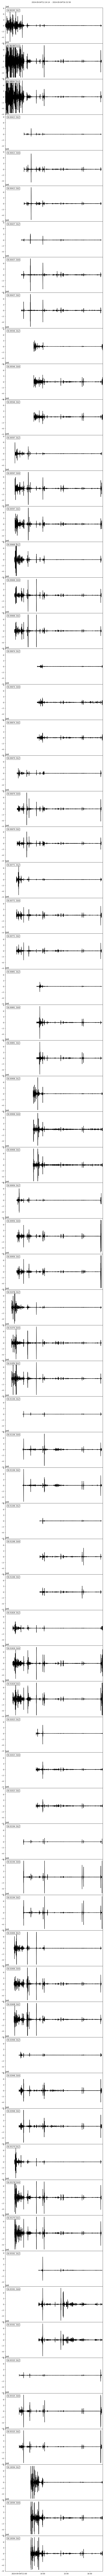

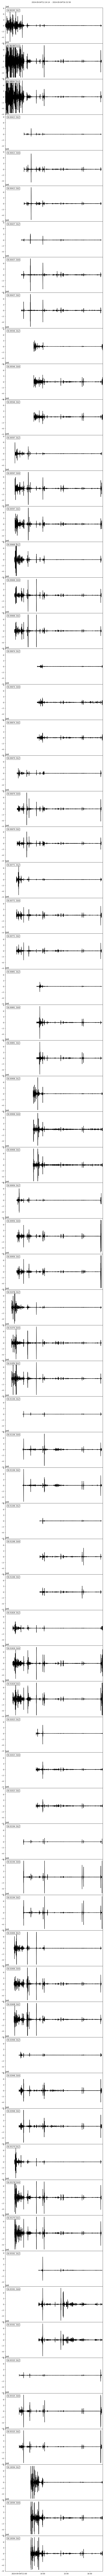

In [20]:
S_antenne.plot()

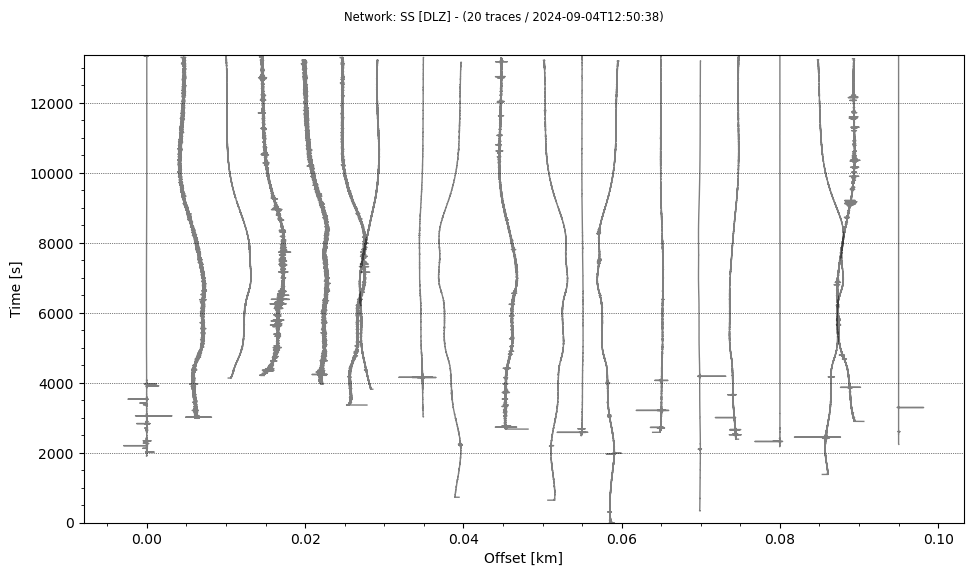

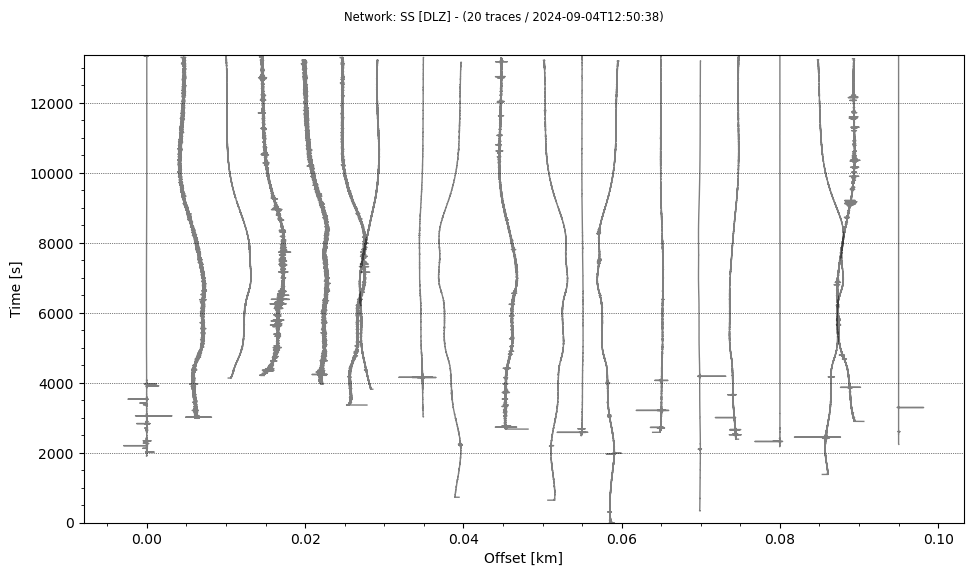

In [21]:
S_profil.select(component='Z').plot(type='section')

In [22]:
#Skeep = S.copy()

## Intervalle d'étude

### Automatique

Sélection du début et de la fin de la periode "calme" d'écoute.

In [23]:
times = []
for T in S_antenne + S_profil:
    times.append((T.stats.starttime, T.stats.endtime))
starttime = max(i[0] for i in times) + 5*60
endtime = min(i[1] for i in times) - 5*60
print(starttime, endtime)

2024-09-04T14:05:46.000000Z 2024-09-04T16:24:18.000000Z


In [24]:
starttime = UTCDateTime('2024-09-04T14:15:00.000000Z')
endtime = UTCDateTime('2024-09-04T16:24:18.000000Z')

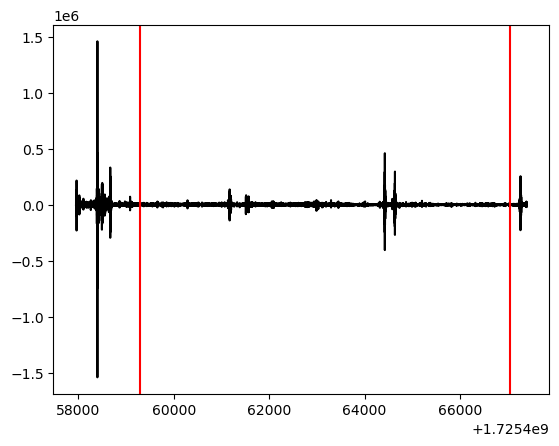

In [25]:
T = S[0]
t, d = T.times(type="utcdatetime"), T.data
plt.plot(t, d, 'k')
plt.axvline(starttime, color='r')
plt.axvline(endtime, color='r')

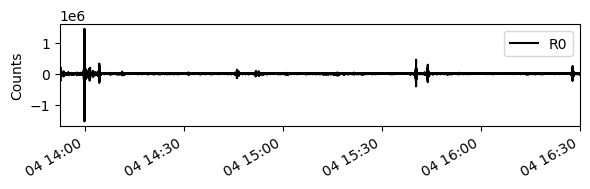

In [26]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(1, 1, 1)
times = T.times("matplotlib")
ax.plot(times, T.data, "k-", label=T.stats.node)
plt.xlim(np.min(times), np.max(times))
plt.ylabel('Counts')
ax.xaxis_date()
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.savefig('figures/sismique_passive_trace_exemple')

## Analyse H/V

### Filtration et nettoyage préliminaire des traces

In [27]:
S.detrend("demean")
S.taper(0.05)
fact_decim = 4
S.decimate(fact_decim) # fact_decim = facteur de décimation (2 = divise par 2 l'échantillonnage)
S = S.trim(starttime, endtime) # retirer les parties inutiles et égaliser la durée de mesure

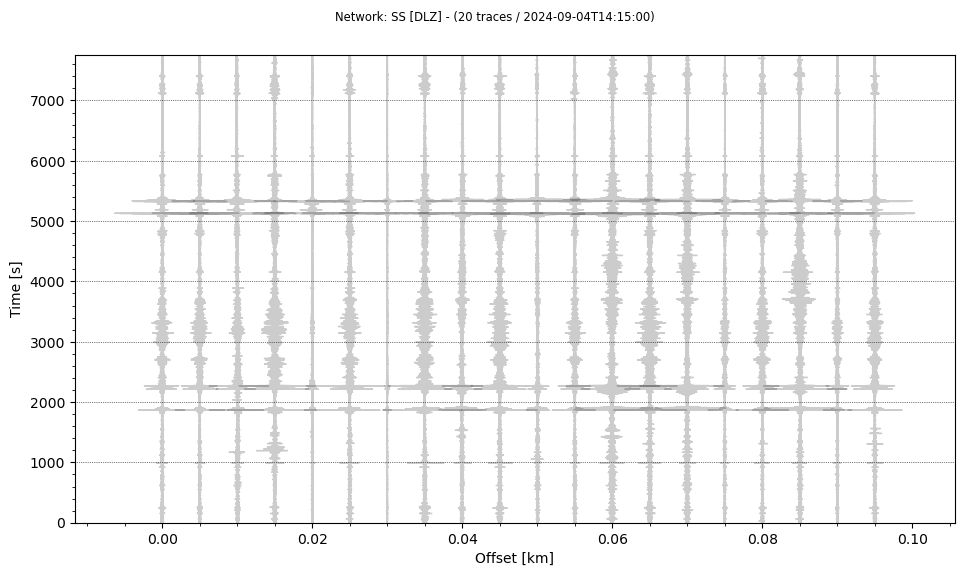

In [28]:
ax = S_profil.select(component='Z').plot(type='section', method='full', scale=2, alpha=0.2, times='matplotlib') # , outfile='sismique_passive_profil_pretraite.png'
# outfile=os.path.join('figures', 'traces.png')

In [29]:
#S.plot()

In [30]:
def spectrogram(T, wlen=10, per_lap=.9, fact_nfft=2):
    data = T.data
    sampling_rate = T.stats.sampling_rate
    nperseg = round(wlen * sampling_rate)
    nfft = round(nperseg * fact_nfft)
    noverlap = round(nperseg * per_lap)

    f, t, Sxx = scipy.signal.spectrogram(
        x=data, fs=sampling_rate, nfft=nfft, nperseg=nperseg, noverlap=noverlap)

    return f, t, Sxx

In [31]:
f, t, Sxx = spectrogram(T)

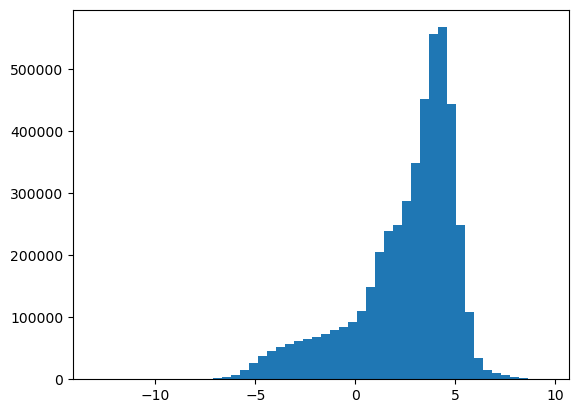

In [32]:
_ = plt.hist(np.log10(Sxx).ravel(), bins=50)

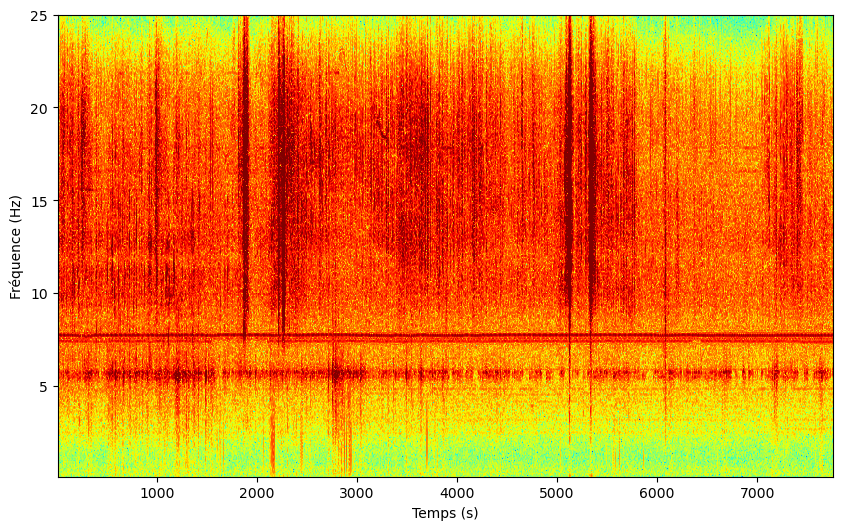

In [33]:
fig = plt.figure(figsize=(10, 6))

plt.pcolormesh(t, f, np.log10(Sxx), cmap='jet', vmin=-5, vmax=6)
#plt.yscale('log')
plt.ylim(.1, 25)
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.savefig('figures/sismique_passive_spectrogramme_HF')

In [34]:
f, t, Sxx = spectrogram(T, wlen=500, per_lap=.9, fact_nfft=1)

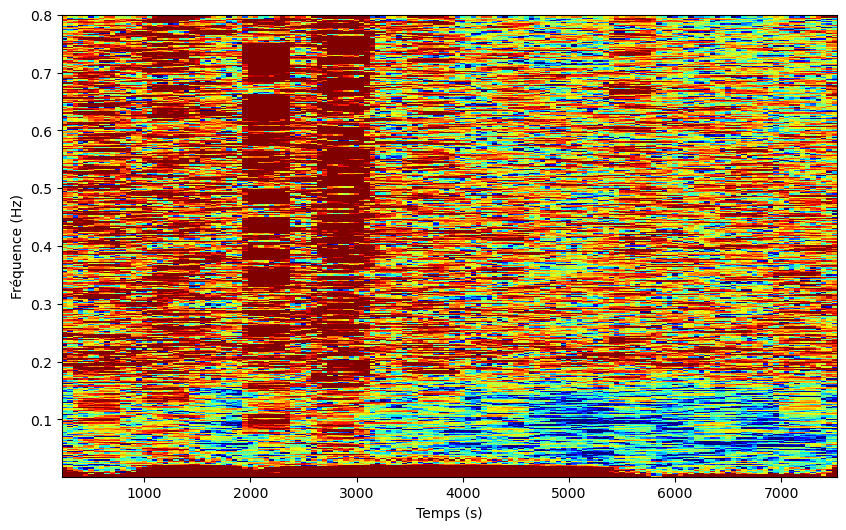

In [35]:
fig = plt.figure(figsize=(10, 6))

plt.pcolormesh(t, f, np.log10(Sxx), cmap='jet', vmin=0, vmax=2)
#plt.yscale('log')
plt.ylim(.001, .8)
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.savefig('figures/sismique_passive_spectrogramme_LF')

### Calcul H/V pour chaque segment

In [36]:
def segments(S, starttime=starttime, endtime=endtime, step=step, fmin=1, fmax=50, fact_smooth=50):
    """calcul le rapport H/V pour chaque segments"""
    T = np.arange(starttime, endtime, step)
    HV = []
    F = []
    for t in T:
        Scut = S.slice(t,t+step)
        Scut.sort(keys=['channel'])
        npts = Scut[0].stats.npts
        dt = Scut[0].stats.delta
        TF = np.zeros((3,npts))
        for i,T in enumerate(Scut):
            TF[i,:] = np.abs(np.fft.fft(T.data))
        f = np.fft.fftfreq(npts,dt)
        ii = np.where((f>=fmin) & (f<=fmax))[0]
        TF = TF[:,ii]
        f = f[ii]
        TFs = konno_ohmachi_smoothing(TF,f,bandwidth=fact_smooth)
        F.append(f)
        HV.append(np.sqrt(0.5*(TFs[0,:]**2+TFs[1,:]**2)) / TFs[2,:])
    HV = np.array(HV[:-1])
    return F, HV

In [37]:
def geometric_mean(values, N):
    """renvoie la moyenne géométrique"""
    return np.power(10, np.sum(np.log10(values), axis=0)/N)

#### Exemple

In [38]:
Snode = node_S('R0')
print(Snode)

# HV sur des fenêtres
F, HV = segments(Snode)

# Moyenne des fenêtres
HVs = geometric_mean(HV, np.shape(HV)[0])

# Fréquence fondamentale
ii = np.where((F[0] > 10) & (F[0] < 40))
i = np.argmax(HVs[ii])
fi = F[0][ii][i]

3 Trace(s) in Stream:
SS.01268..DLZ | 2024-09-04T14:15:00.000000Z - 2024-09-04T16:24:18.000000Z | 62.5 Hz, 484876 samples
SS.01268..DLE | 2024-09-04T14:15:00.000000Z - 2024-09-04T16:24:18.000000Z | 62.5 Hz, 484876 samples
SS.01268..DLN | 2024-09-04T14:15:00.000000Z - 2024-09-04T16:24:18.000000Z | 62.5 Hz, 484876 samples


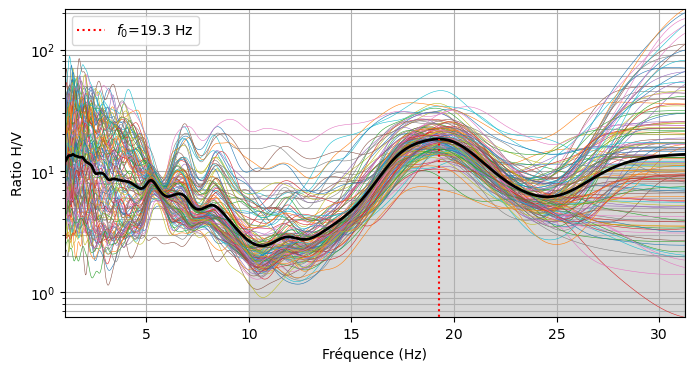

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for k, hv in enumerate(HV):
    ax.plot(F[k],hv,linewidth=0.4)
ax.plot(F[0],HVs,linewidth=2,color='k')

ax.fill_between(F[0][ii], HVs[ii], alpha=.3, color='grey')
ax.vlines(fi, 0, HVs[ii][i], color='red', linestyle=':', label='$f_0$='f'{fi:.1f} Hz')

ax.grid(True, which='both')
ax.set_xlim(np.min(F[0]), np.max(F[0]))
ax.set_ylim(np.min(HV), np.max(HV))
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Ratio H/V')
ax.set_yscale('log')
plt.legend()

## Généralisation

R0
R1-01
R1-02
R1-03
R1-04
R1-05
R2-01
R2-02
R2-03
R2-04
R2-05
R2-06
R3-01
R3-02
R3-03
R3-04
R3-05
R3-06
R4-01
R4-02


/tmp/ipykernel_7084/3640912689.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))


R4-03
R4-04
R4-05
R4-06
D0
D5
D10
D15
D20
D25
D30
D35
D40
D45
D50
D55
D60
D65
D70
D75
D80
D85
D90
D95


<Figure size 640x480 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

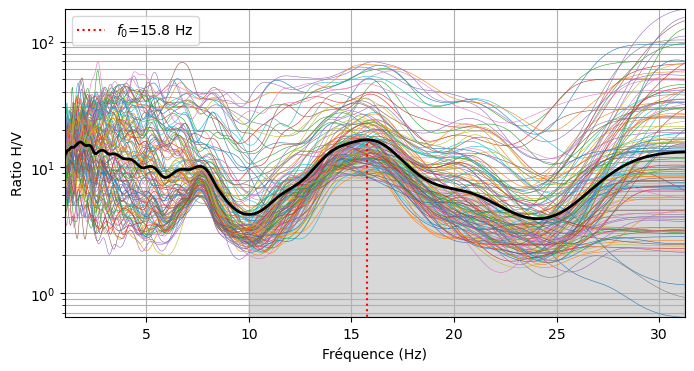

In [40]:
HVs_node = []
Fi = []
for row in df.iterrows():
    name = row[0]
    print(name)
    Snode = node_S(name) # récupération des traces d'une node qui a été filtré str(row[1]['SN'])
    
    # H/V
    F, HV = segments(Snode)
    HVs = geometric_mean(HV, np.shape(HV)[0])
    HVs_node.append(HVs)
    
    # Fréquence fondamentale
    ii = np.where((F[0] > 10) & (F[0] < 40))
    i = np.argmax(HVs[ii])
    fi = F[0][ii][i]
    Fi.append(fi)
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    for k, hv in enumerate(HV):
        ax.plot(F[k],hv,linewidth=0.4)
    ax.plot(F[0],HVs,linewidth=2,color='k')

    ax.fill_between(F[0][ii], HVs[ii], alpha=.3, color='grey')
    ax.vlines(fi, 0, HVs[ii][i], color='red', linestyle=':', label='$f_0$='f'{fi:.1f} Hz')

    ax.grid(True, which='both')
    ax.set_xlim(np.min(F[0]), np.max(F[0]))
    ax.set_ylim(np.min(HV), np.max(HV))
    ax.set_xlabel('Fréquence (Hz)')
    ax.set_ylabel('Ratio H/V')
    ax.set_yscale('log')
    plt.legend(loc='upper left')

    fig.savefig(f'figures/HV/{name}.png')
    plt.close()
    
HVs_node = np.array(HVs_node)

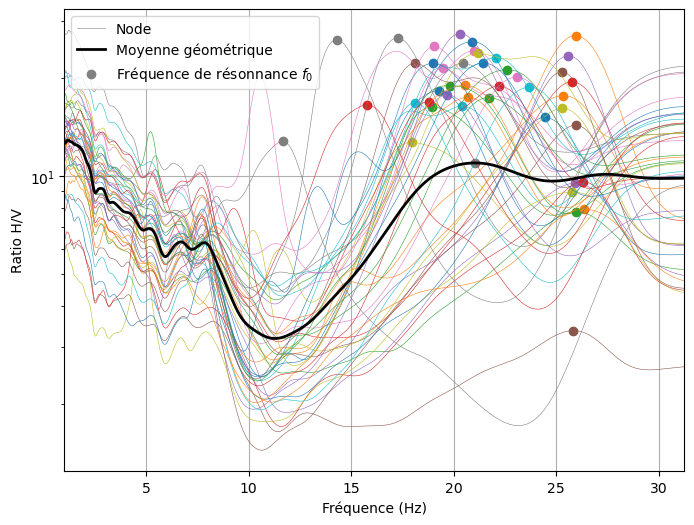

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

Fi = []
for HVs in HVs_node:
    plt.semilogy(F[0], HVs, linewidth=0.4)
    ii = np.where(F[0] > 10)
    i = np.argmax(HVs[ii])
    fi = F[0][ii][i]
    Fi.append(fi)
    plt.scatter(fi, HVs[ii][i])
HVs_nodes = np.array([geometric_mean(e, np.shape(e)[0]) for e in HVs_node.T])
i = np.argmax(HVs_nodes[ii])
plt.plot(F[0], HVs_nodes, linewidth=0.4, color='grey', label='Node')
plt.plot(F[0], HVs_nodes, linewidth=2, color='k', label='Moyenne géométrique')
plt.scatter(F[0][ii][i], HVs_nodes[ii][i], c='grey', label='Fréquence de résonnance $f_0$')
plt.grid()
plt.xlim(np.min(F[0]), np.max(F[0]))
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Ratio H/V')
plt.legend()

plt.savefig(f'figures/sismique_passive_HV_nodes.png')

(array([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 2., 3., 3., 2.,
        3., 3., 3., 1., 2., 1., 1., 1., 0., 1., 3., 4., 6.]),
 array([11.66355638, 12.15342575, 12.64329512, 13.13316449, 13.62303386,
        14.11290323, 14.60277259, 15.09264196, 15.58251133, 16.0723807 ,
        16.56225007, 17.05211943, 17.5419888 , 18.03185817, 18.52172754,
        19.01159691, 19.50146628, 19.99133564, 20.48120501, 20.97107438,
        21.46094375, 21.95081312, 22.44068248, 22.93055185, 23.42042122,
        23.91029059, 24.40015996, 24.89002933, 25.37989869, 25.86976806,
        26.35963743]),
 <BarContainer object of 30 artists>)

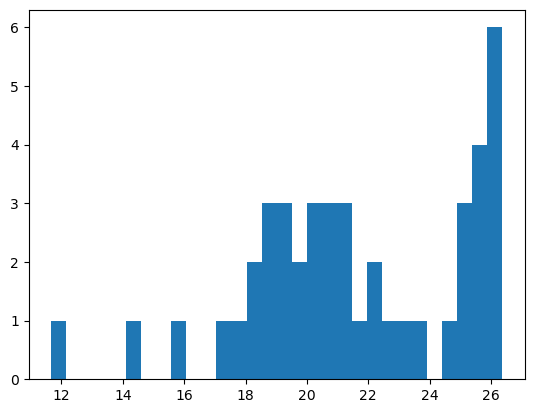

In [44]:
plt.hist(Fi, bins=30)

In [45]:
df_gnss_antenne = pd.read_csv('data/gnss_sismique_passive_antenne.csv')
df_gnss_antenne.index = df_antenne.index

In [46]:
df_gnss_profil = pd.read_csv('data/gnss_sismique_passive_profil.csv')
df_gnss_profil = df_gnss_profil.iloc[::-1]
df_gnss_profil.index = df_profil.index

In [47]:
df_gnss = pd.concat([df_gnss_antenne, df_gnss_profil])

In [54]:
df_gnss.head()

Name   Latitude  Longitude  EllipsoidHeight  \
Node                                                     
R0     SP.GR1.0  48.491006   7.288288       717.320947   
R1-01  SP.GR1.1  48.491048   7.288306       716.952588   
R1-02  SP.GR1.2  48.491011   7.288356       717.072591   
R1-03  SP.GR1.3  48.490966   7.288325       717.523095   
R1-04  SP.GR1.4  48.490963   7.288265       717.904694   

                     TimeStamp            X             Y            A  
Node                                                                    
R0     2024-09-03T15:06:36.670  6.829796e+06  1.016699e+06  668.581004  
R1-01  2024-09-03T15:07:16.310  6.829801e+06  1.016700e+06  668.212802  
R1-02  2024-09-03T15:07:57.620  6.829797e+06  1.016704e+06  668.332739  
R1-03  2024-09-03T15:08:22.670  6.829792e+06  1.016702e+06  668.783064  
R1-04  2024-09-03T15:08:48.560  6.829791e+06  1.016698e+06  669.164587

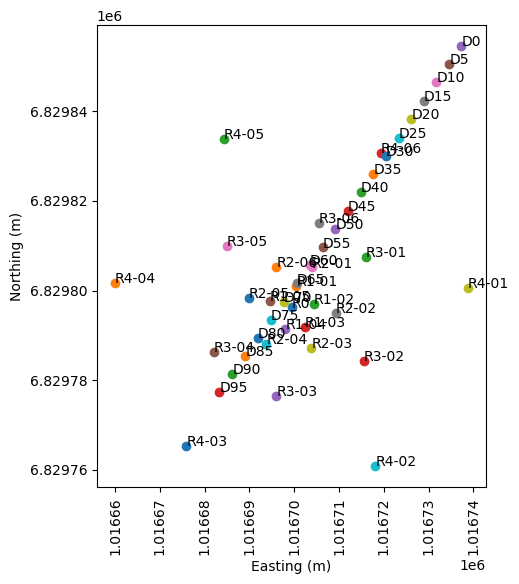

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for k, row in enumerate(df_gnss.iterrows()):
    node, serie = row
    plt.scatter(serie[' Y '], serie[' X ']) # , c=Fi[k]
    plt.annotate(node, (serie[' Y '], serie[' X ']))
ax.set_aspect('equal', adjustable='box')

ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xticks(rotation=90)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.savefig(f'figures/sismique_passive_pos.png')

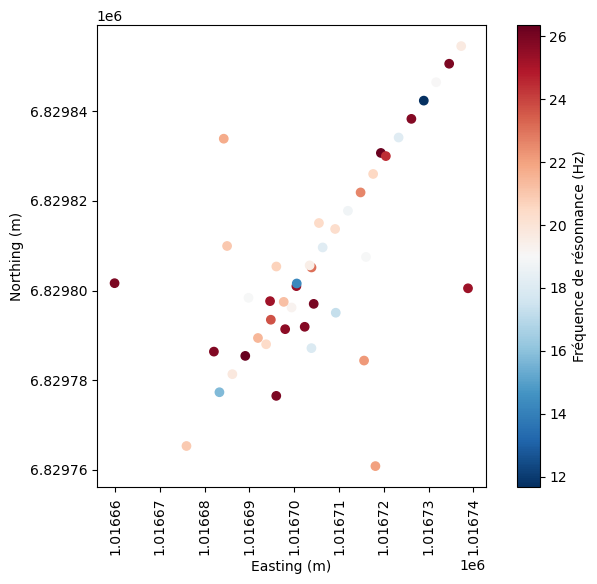

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = plt.scatter(df_gnss[' Y '], df_gnss[' X '], c=Fi, cmap="RdBu_r") # 
ax.set_aspect('equal', adjustable='box')
cb = plt.colorbar(im, label='Fréquence de résonnance (Hz)')

ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xticks(rotation=90)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.savefig(f'figures/sismique_passive_carte_HV.png')

# $F_0 = \frac{\beta}{4H}$

In [52]:
Fi = np.array(Fi) # (Hz=1/s)
beta = 3000 # Vs (m/s)
H = beta/(4*Fi) # (m)

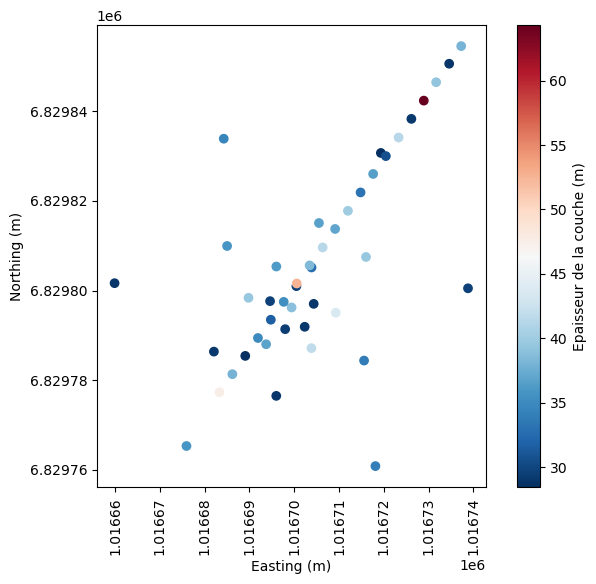

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = plt.scatter(df_gnss[' Y '], df_gnss[' X '], c=H, cmap="RdBu_r") # 
ax.set_aspect('equal', adjustable='box')
cb = plt.colorbar(im, label='Epaisseur de la couche (m)')

ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xticks(rotation=90)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

plt.savefig(f'figures/sismique_passive_carte_H.png')